In [1]:
library(dplyr)
library(ggplot2)
library(tseries)
library(pracma)
library(latex2exp)
library(nortsTest)

Warning message:
"pakiet 'dplyr' został zbudowany w wersji R 4.2.2"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.2.2"
Warning message:
"pakiet 'tseries' został zbudowany w wersji R 4.2.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"pakiet 'latex2exp' został zbudowany w wersji R 4.2.2"
Warning message:
"pakiet 'nortsTest' został zbudowany w wersji R 4.2.2"
Registered S3 methods overwritten by 'nortsTest':
  method      from    
  autoplot.ts forecast
  fortify.ts  forecast



In [2]:
emp_ACVF <- function(X,h){
    n <- length(X)
    xm <- mean(X)
    X1 <- X[1:(n-abs(h))]
    X2 <- X[(1+abs(h)):n]
    return(1/n*sum((X1-xm)*(X2-xm)))
}

In [3]:
emp_acorr <- function(X,h){
    Z <- emp_ACVF(X,h)
    Y <- emp_ACVF(X,0)
    return(Z/Y)
}

In [136]:
base_data <- read.csv('../part1/data.csv')

In [137]:
wro_data <- base_data[base_data$loc=="Wrocław" & base_data$type=='PM10',][,2:7]

In [138]:
wro_data_train <- wro_data[wro_data$year<2019 | (wro_data$year==2019 & !wro_data$month %in% c(11,12)),]
wro_data_test <- wro_data[wro_data$year==2019 & wro_data$month %in% c(11,12),]

In [139]:
wro_data_train <- wro_data_train %>% arrange(year,month,day)
Xt <- data.frame(n=1:length(wro_data_train$value), val=wro_data_train$value)
Xt <- Xt[!is.na(Xt$val) & Xt$val<100,]

In [140]:
Xt_test <- data.frame(n=305:365, val=wro_data_test$value)
Xt_test <- Xt_test[!is.na(Xt_test$val) & Xt_test$val<100,]

Saving 10 x 6.67 in image


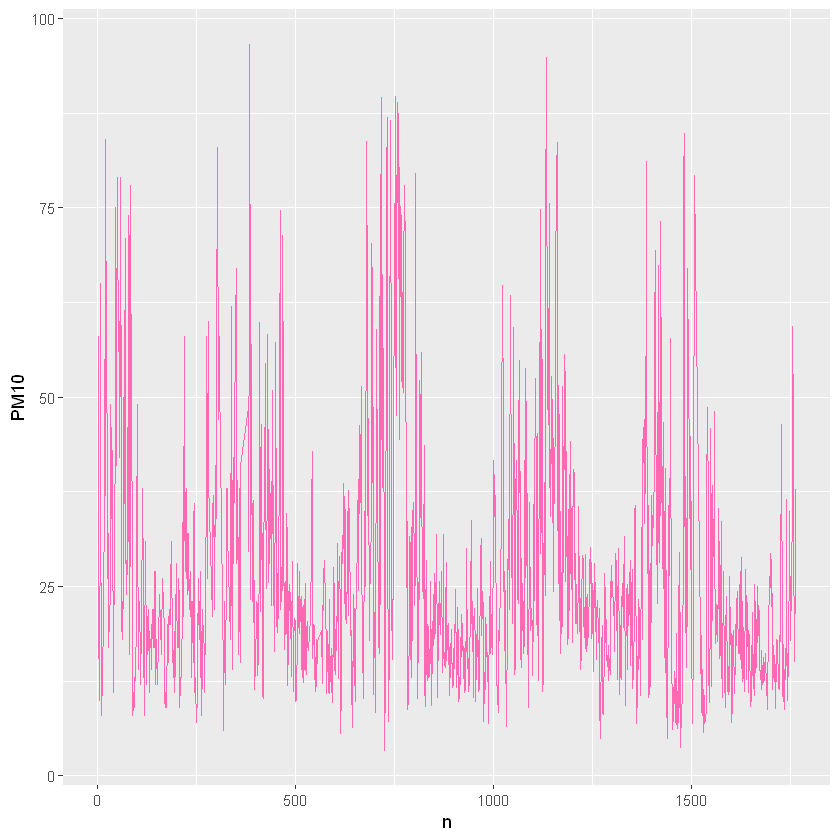

In [141]:
wro_plot <- ggplot(Xt, aes(n,val))+geom_line(col='hotpink')+ylab('PM10')
wro_plot
ggsave('wro_plot.jpg', wro_plot, 'jpg', width=10)

In [142]:
h <- 1:1000
corr1 <- c()
for(i in h) corr1[i] <- emp_acorr(Xt$val,i)
df_h <- data.frame(h,corr1)

Saving 10 x 6.67 in image


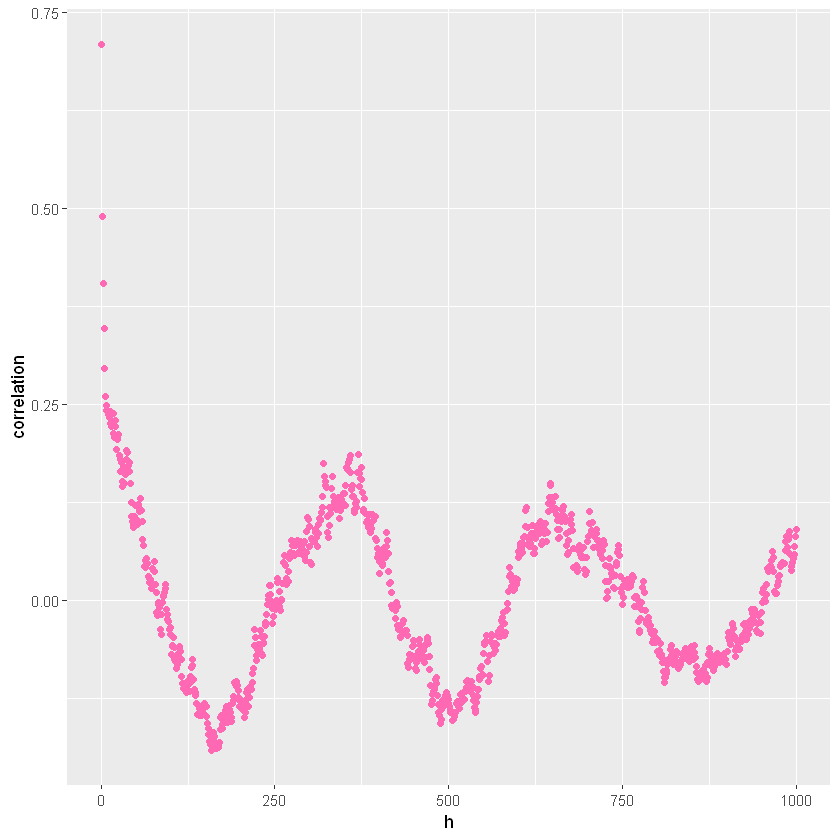

In [143]:
wro_corr_plot <- ggplot(df_h, aes(h,corr1))+geom_point(col='hotpink')+ylab('correlation')
wro_corr_plot
ggsave('wro_corr_plot.jpg', wro_corr_plot, 'jpg', width=10)

# Test stacjonarności

In [144]:
adf.test(Xt$val)$p.value

Warning message in adf.test(Xt$val):
"p-value smaller than printed p-value"


[1] 0.01

# Dopasowanie trendu

In [145]:
lm0 <- polyfit(Xt$n, Xt$val, 0)
lm1 <- polyfit(Xt$n, Xt$val, 1)
lm2 <- polyfit(Xt$n, Xt$val, 2)
lm3 <- polyfit(Xt$n, Xt$val, 3)
lm4 <- polyfit(Xt$n, Xt$val, 4)
lm5 <- polyfit(Xt$n, Xt$val, 5)

In [146]:
lm1_approx <- polyval(lm1,Xt$n)
lm2_approx <- polyval(lm2,Xt$n)
lm3_approx <- polyval(lm3,Xt$n)
lm4_approx <- polyval(lm4,Xt$n)
lm0_approx <- polyval(lm0,Xt$n)

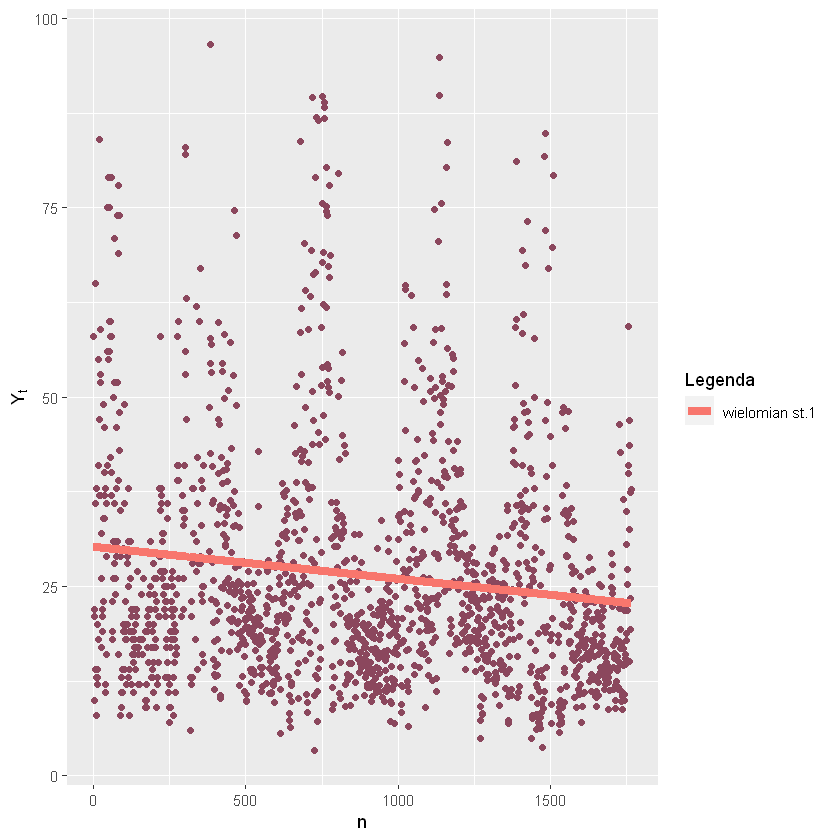

In [147]:
trend_fit <- ggplot(Xt, aes(n,val))+geom_point(col='palevioletred4')+
    #geom_line(aes(y=lm0_approx,col='wielomian st.0'),linewidth=2.5)+
    geom_line(aes(y=lm1_approx,col='wielomian st.1'),linewidth=2.5)+
    #geom_line(aes(y=lm2_approx,col='wielomian st.2'),linewidth=2.5)+
    #geom_line(aes(y=lm3_approx,col='wielomian st.3'),linewidth=2.5)+
    #geom_line(aes(y=lm4_approx,col='wielomian st.4'),linewidth=2.5)+
    #scale_color_manual(values=c('palevioletred2','palevioletred4'))+
    guides(col=guide_legend(title="Legenda"))+ylab(TeX('$Y_t$'))
trend_fit
#ggsave('trend_fit.jpg', trend_fit, 'jpg', width=10)

In [148]:
Xt$val_no_trend <- Xt$val-lm1_approx

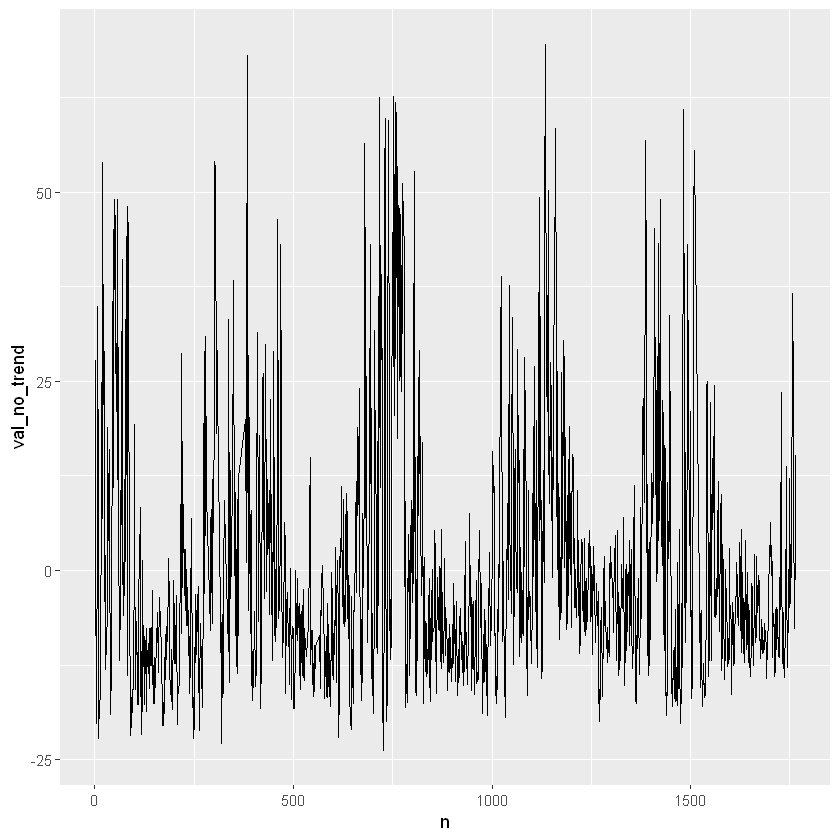

In [149]:
ggplot(Xt, aes(n,val_no_trend))+geom_line()

In [150]:
corr2 <- c()
for(i in df_h$h) corr2[i] <- emp_acorr(Xt$val_no_trend,i)
df_h$corr2 <- corr2

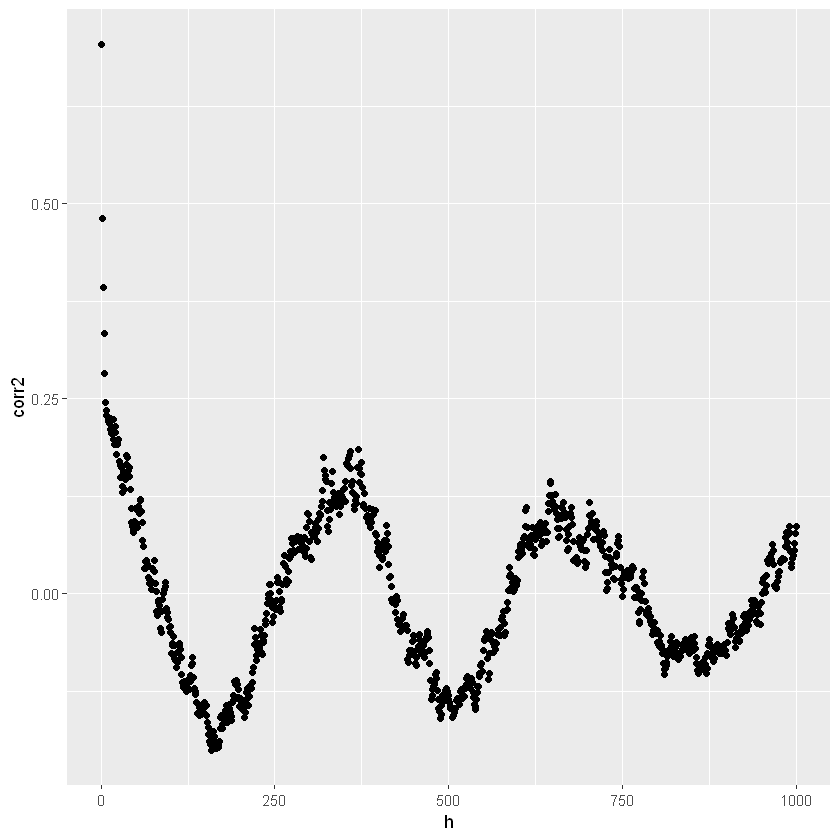

In [151]:
ggplot(df_h, aes(h,corr2))+geom_point()

# Sezonowość

In [152]:
y15 <- Xt[Xt$n<=365,]
y16 <- Xt[Xt$n>365 & Xt$n<=2*365,]
y16$n <- y16$n-365
y17 <- Xt[Xt$n>2*365 & Xt$n<=3*365,]
y17$n <- y17$n-2*365
y18 <- Xt[Xt$n>3*365 & Xt$n<=4*365,]
y18$n <- y18$n-3*365
y19 <- Xt[Xt$n>4*365 & Xt$n<=5*365,]
y19$n <- y19$n-4*365

In [153]:
yearly <- y15 %>% full_join(y=y16, by='n') %>% full_join(y=y17, by='n') %>% full_join(y=y18, by='n') %>% full_join(y=y19, by='n') %>% arrange(n)

In [154]:
colnames(yearly)[c(2,4,6,8,10)] <- c('v1','v2','v3','v4','v5')

In [155]:
mean_vec <- c()
for(i in 1:length(yearly$n)) {
    base <- yearly[yearly$n==yearly$n[i],]
    mean_vec[i] <- mean(c(yearly$v1[i],yearly$v2[i],yearly$v3[i],yearly$v4[i],yearly$v5[i]), na.rm=TRUE)
}

In [156]:
season_vals <- data.frame(yearly$n, mean_vec)
colnames(season_vals) <- c('n','s_val')

In [157]:
s15 <- y15 %>% full_join(y=season_vals, by='n')
s15$val_no_s2 <- s15$val_no_trend - s15$s_val
s115 <- s15[!is.na(s15$val),]
s16 <- y16 %>% full_join(y=season_vals, by='n')
s16$val_no_s2 <- s16$val_no_trend - s16$s_val
s116 <- s16[!is.na(s16$val),]
s17 <- y17 %>% full_join(y=season_vals, by='n')
s17$val_no_s2 <- s17$val_no_trend - s17$s_val
s117 <- s17[!is.na(s17$val),]
s18 <- y18 %>% full_join(y=season_vals, by='n')
s18$val_no_s2 <- s18$val_no_trend - s18$s_val
s118 <- s18[!is.na(s18$val),]
s19 <- y19 %>% full_join(y=season_vals, by='n')
s19$val_no_s2 <- s19$val_no_trend - s19$s_val
s119 <- s19[!is.na(s19$val),]

In [158]:
Xt$val_no_s2 <- c(s115$val_no_s2,s116$val_no_s2,s117$val_no_s2,s118$val_no_s2,s119$val_no_s2)

Saving 10 x 6.67 in image


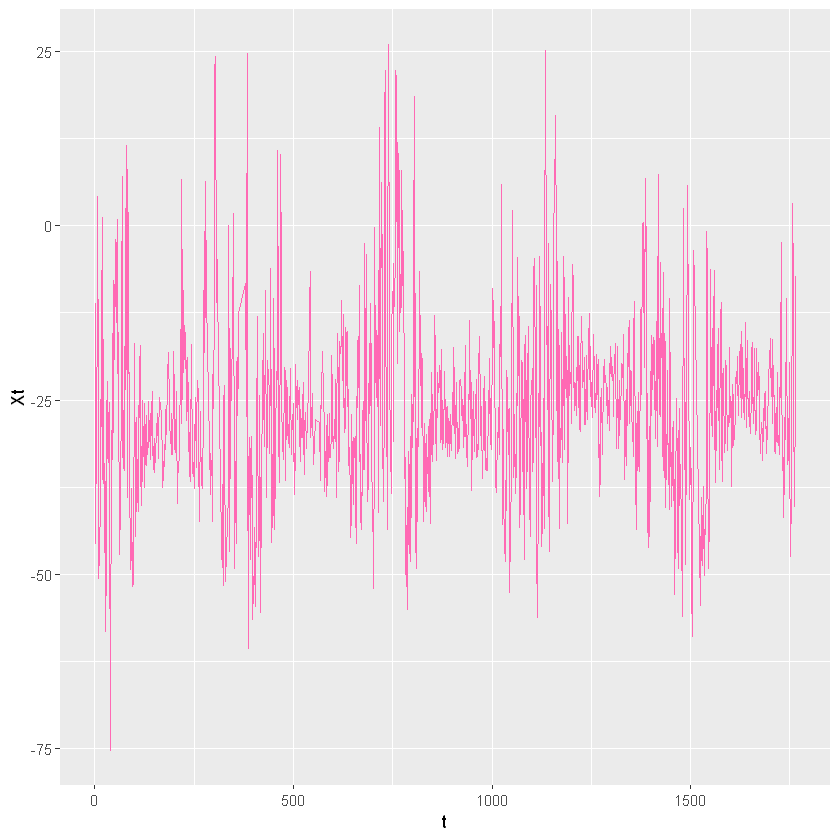

In [159]:
no_season_plot <- ggplot(Xt, aes(n,val_no_s2))+geom_line(col='hotpink')+xlab('t')+ylab('Xt')
no_season_plot
ggsave('no_season_plot.jpg', no_season_plot, 'jpg', width=10)

In [160]:
corr3 <- c()
for(i in df_h$h) corr3[i] <- emp_acorr(Xt$val_no_s2,i)
df_h$corr3 <- corr3

Saving 10 x 6.67 in image


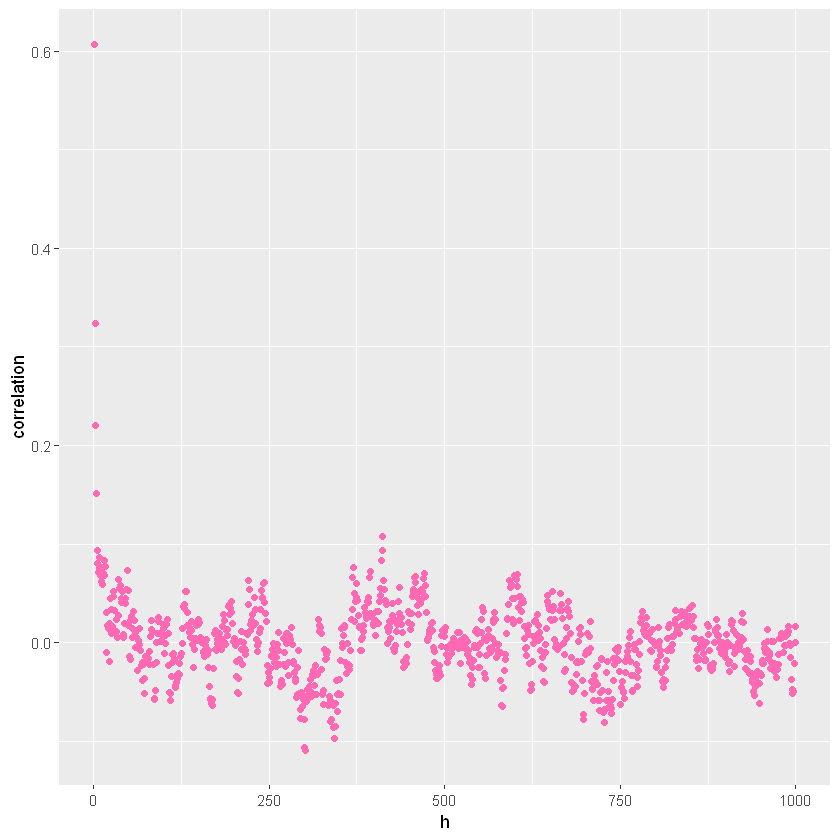

In [161]:
no_season_corr_plot <- ggplot(df_h, aes(h,corr3))+geom_point(col='hotpink')+ylab('correlation')
no_season_corr_plot
ggsave('no_season_corr_plot.jpg', no_season_corr_plot, 'jpg', width=10)

# Test stacjonarności

In [162]:
adf.test(Xt$val_no_s2)

Warning message in adf.test(Xt$val_no_s2):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  Xt$val_no_s2
Dickey-Fuller = -9.397, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


In [164]:
#write.csv(Xt, 'wroclaw_notrend_noseason.csv')

# Dopasowanie parametrów

In [88]:
p <- c()
q <- c()
bic_vals <- c()
k <- 1
for(i in 1:5){
    for(j in 1:5){
        model <- arima(Xt$val_no_s2,order=c(i,0,j))
        bic_vals[k] <- BIC(model)
        p[k] <- i
        q[k] <- j
        k <- k+1
    }
}

Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"


In [89]:
df_bic <- data.frame(p,q,bic_vals)

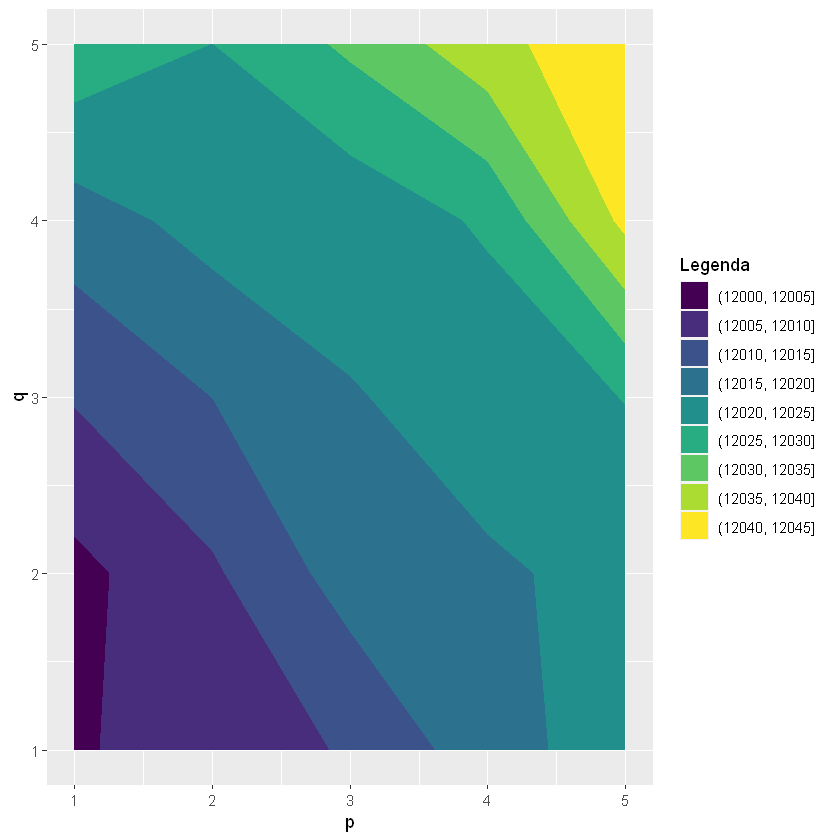

In [90]:
color_pal1 <- colorRampPalette(c('purple4','hotpink2','lightpink'))
bic_10 <- ggplot(df_bic, mapping=aes(p,q,z=bic_vals))+geom_contour_filled()+
    guides(fill=guide_legend(title="Legenda"))
bic_10

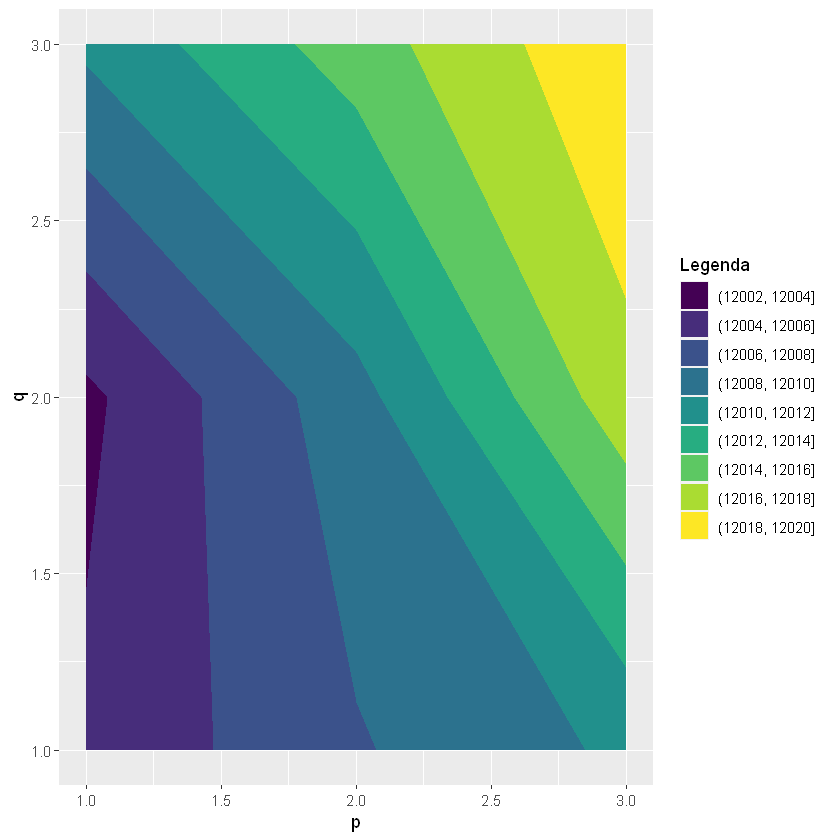

In [91]:
bic_3 <- ggplot(df_bic[df_bic$p<=3&df_bic$q<=3,], mapping=aes(p,q,z=bic_vals))+geom_contour_filled()+
    guides(fill=guide_legend(title="Legenda"))
bic_3

In [165]:
model <- arima(Xt$val_no_s2,order=c(1,0,2), method='ML')

In [166]:
model


Call:
arima(x = Xt$val_no_s2, order = c(1, 0, 2), method = "ML")

Coefficients:
         ar1      ma1      ma2  intercept
      0.6769  -0.0203  -0.1381   -26.3645
s.e.  0.0577   0.0660   0.0470     0.6032

sigma^2 estimated as 87.91:  log likelihood = -5983.27,  aic = 11976.55

In [167]:
k <- arima.sim(n=365,list(ar=c(model$coef[[1]],model$coef[[2]]),
                          ma=c(model$coef[[3]],model$coef[[4]])),
              sd=sqrt(102.2))

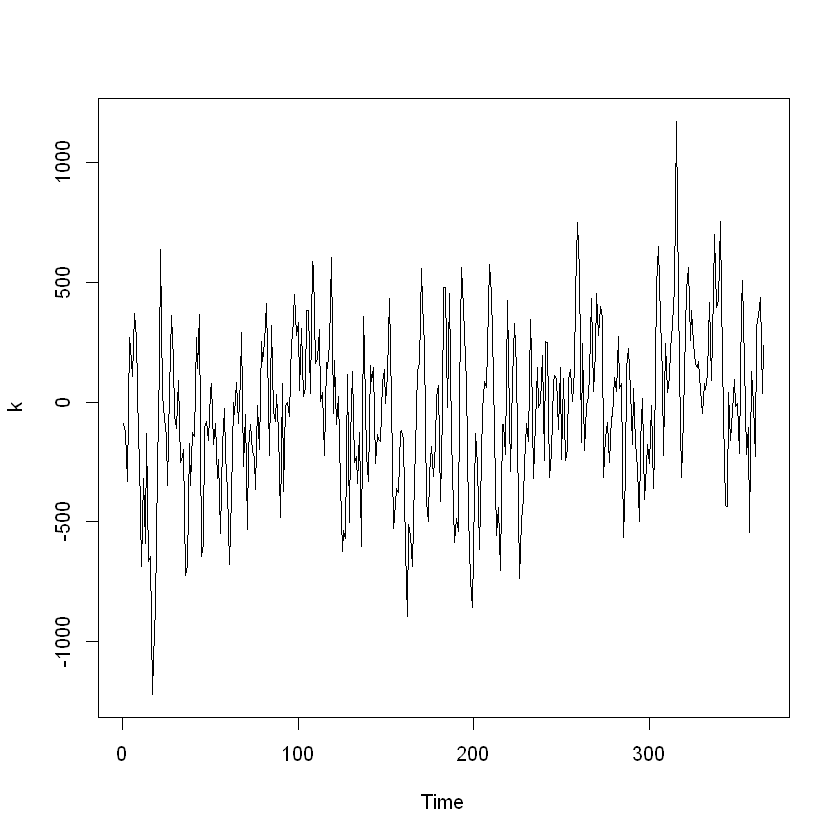

In [168]:
plot(k)

In [169]:
ei <- residuals(model)

Saving 10 x 6.67 in image


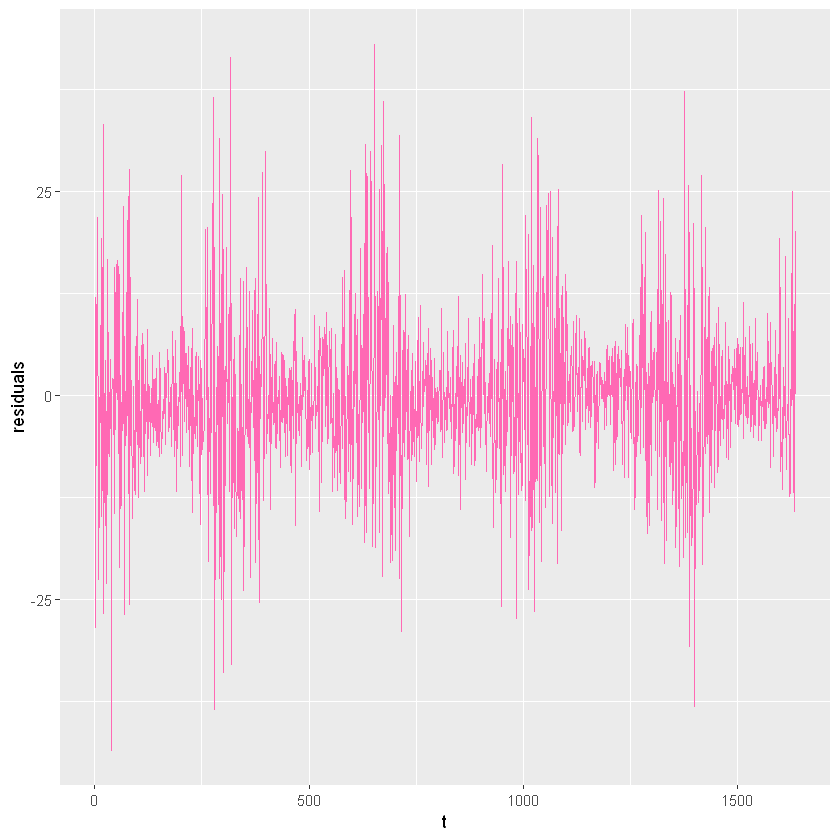

In [170]:
ei_plot <- ggplot(mapping=aes(1:length(c(ei)),c(ei)))+geom_line(col='hotpink')+xlab('t')+ylab('residuals')
ei_plot
ggsave('ei_plot.jpg', ei_plot, 'jpg', width=10)

In [171]:
Box.test(ei, type = "Ljung")


	Box-Ljung test

data:  ei
X-squared = 6.2449e-05, df = 1, p-value = 0.9937


In [172]:
arch.test(ei)


	Box-Ljung test

data:  y^2
X-squared = 147.85, df = 2, p-value < 2.2e-16
alternative hypothesis: y is heteroscedastic


In [119]:
p <- c()
q <- c()
aic_vals <- c()
k <- 1
for(i in 1:5){
    for(j in 1:5){
        model <- arima(Xt$val_no_s2,order=c(i,0,j))
        aic_vals[k] <- AIC(model)
        p[k] <- i
        q[k] <- j
        k <- k+1
    }
}

Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"
Warning message in arima(Xt$val_no_s2, order = c(i, 0, j)):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"


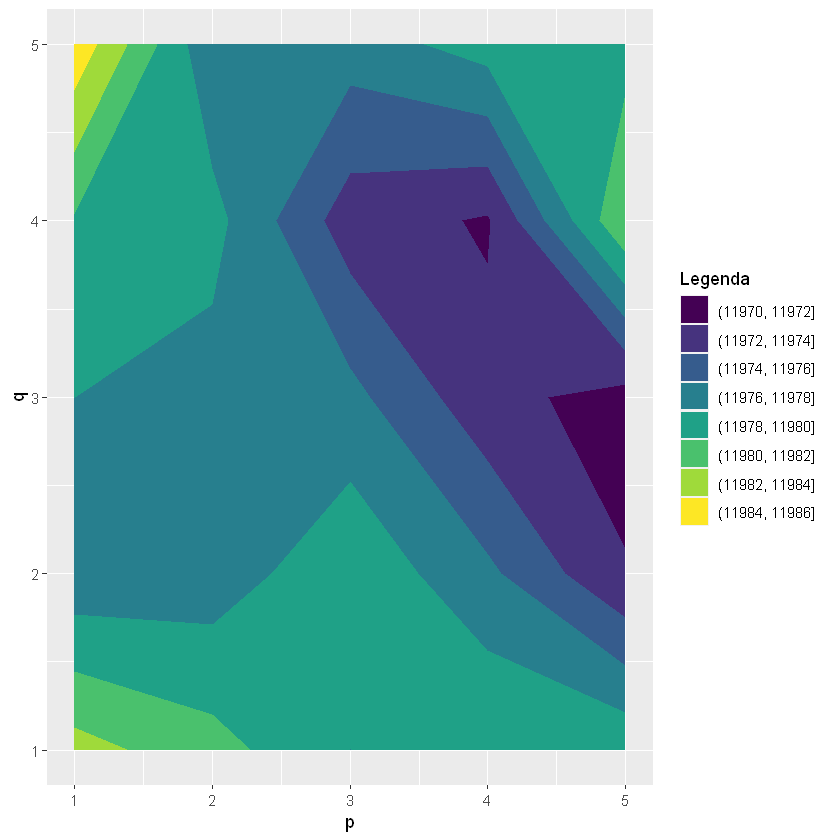

In [120]:
df_aic <- data.frame(p,q,aic_vals)
aic_10 <- ggplot(df_aic, mapping=aes(p,q,z=aic_vals))+geom_contour_filled()+
    guides(fill=guide_legend(title="Legenda"))
aic_10

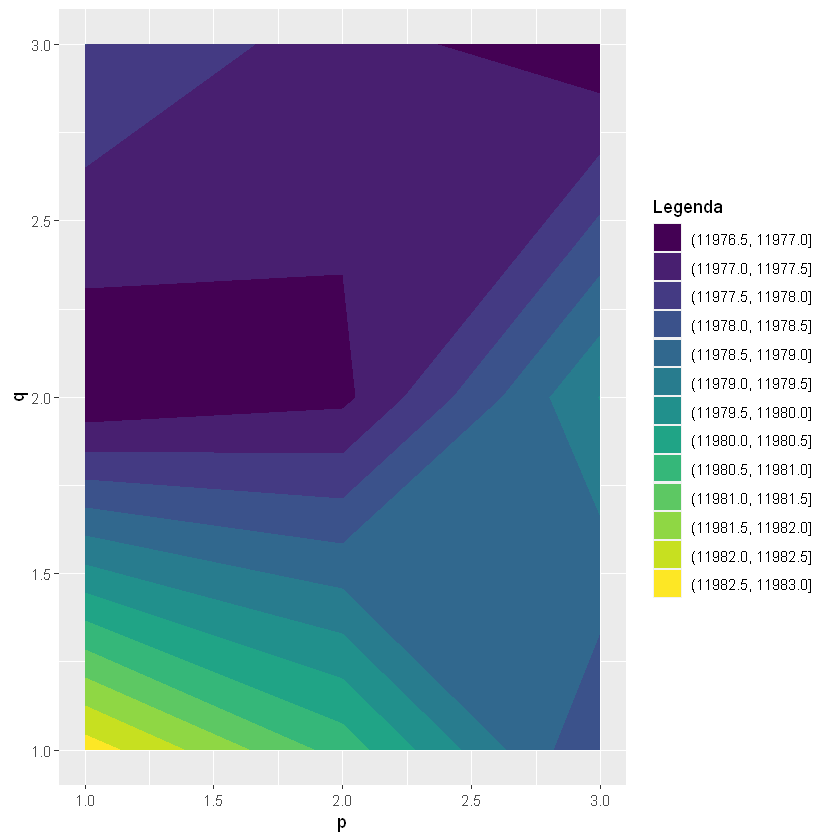

In [121]:
df_aic <- data.frame(p,q,aic_vals)
aic_3 <- ggplot(df_aic[df_aic$p<=3 & df_aic$q<=3,], mapping=aes(p,q,z=aic_vals))+geom_contour_filled()+
    guides(fill=guide_legend(title="Legenda"))
aic_3

In [173]:
model2 <- arima(Xt$val_no_s2,order=c(4,0,4), method='ML')
model2

Warning message in arima(Xt$val_no_s2, order = c(4, 0, 4), method = "ML"):
"prawdopodobny problem zbieżności: 'optim' zwrócił kod= 1"



Call:
arima(x = Xt$val_no_s2, order = c(4, 0, 4), method = "ML")

Coefficients:
          ar1     ar2     ar3      ar4     ma1      ma2      ma3      ma4
      -0.1227  0.8449  0.6358  -0.4241  0.7866  -0.4536  -0.9681  -0.1228
s.e.   0.0724  0.0529  0.0569   0.0535  0.0756   0.0834   0.0616   0.0497
      intercept
       -26.1898
s.e.     0.8406

sigma^2 estimated as 87.05:  log likelihood = -5975.34,  aic = 11970.67

In [174]:
k2 <- arima.sim(n=365,list(ar=c(model$coef[[1]],model$coef[[2]]),
                          ma=c(model$coef[[3]],model$coef[[4]]),
              sd=sqrt(87.81)))

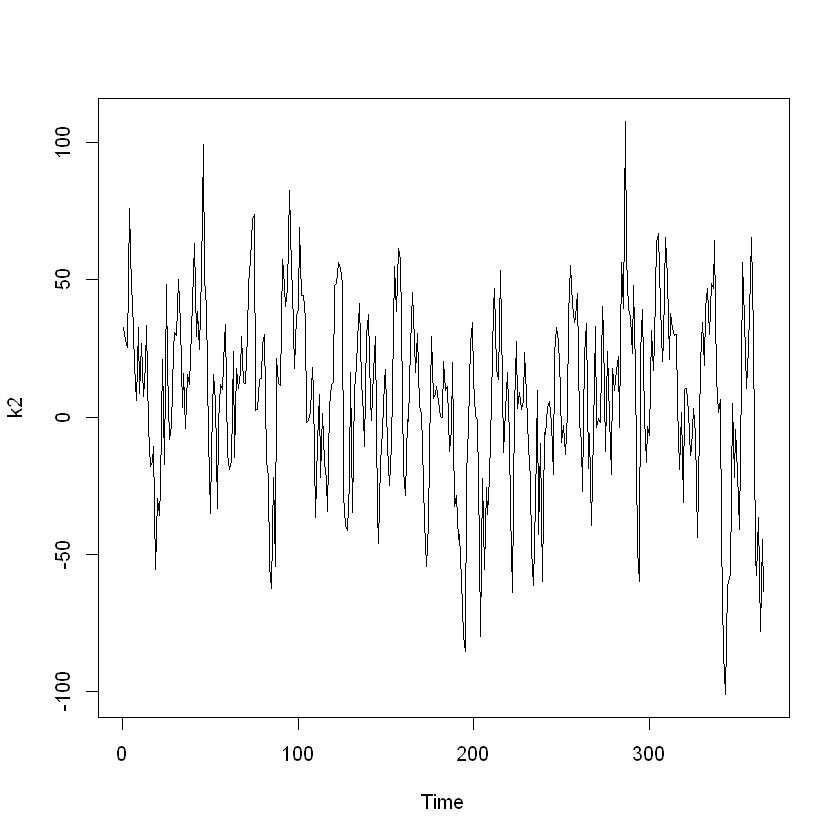

In [175]:
plot(k2)

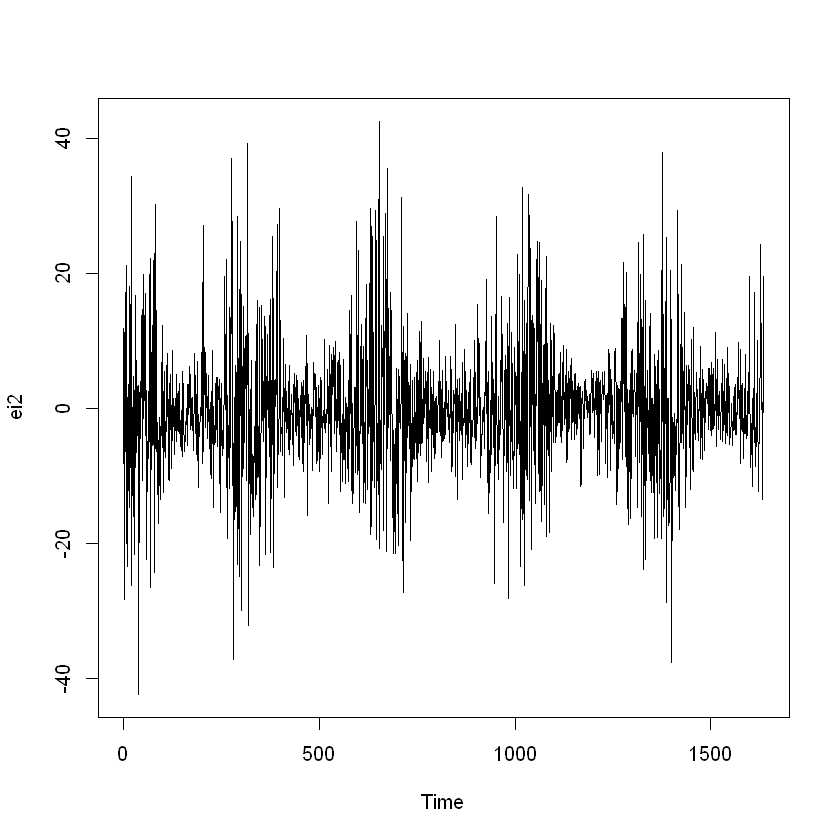

In [176]:
ei2 <- residuals(model2)
plot(ei2)

# Dekompozycja danych testowych

In [177]:
Xt_test$val_no_trend <- Xt_test$val-polyval(lm1,(4*365+Xt_test$n))

In [178]:
Xt_test <- Xt_test %>% left_join(y=season_vals, by='n')

In [179]:
Xt_test$val_no_s2 <- Xt_test$val_no_trend-Xt_test$s_val

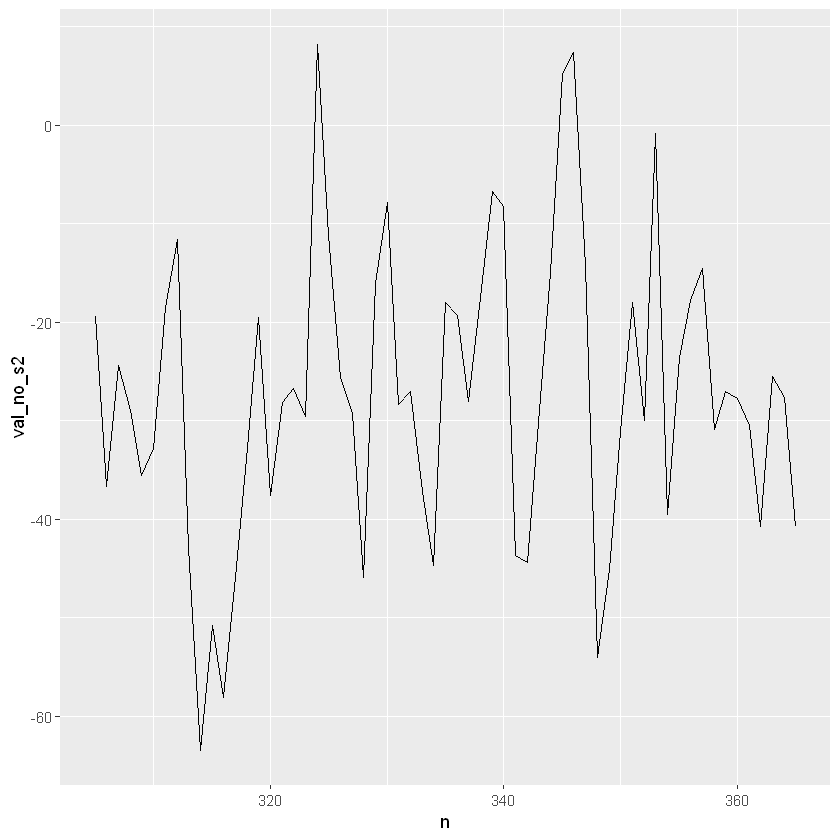

In [180]:
ggplot(Xt_test, aes(n, val_no_s2))+geom_line()

In [181]:
#write.csv(Xt_test, 'wroclaw_notrend_noseason_test.csv')

In [201]:
Xt_all <- data.frame(n=1:length(wro_data$loc), val=wro_data$value)
Xt_all <- Xt_all[!is.na(Xt_all$val) & Xt_all$val<100,]

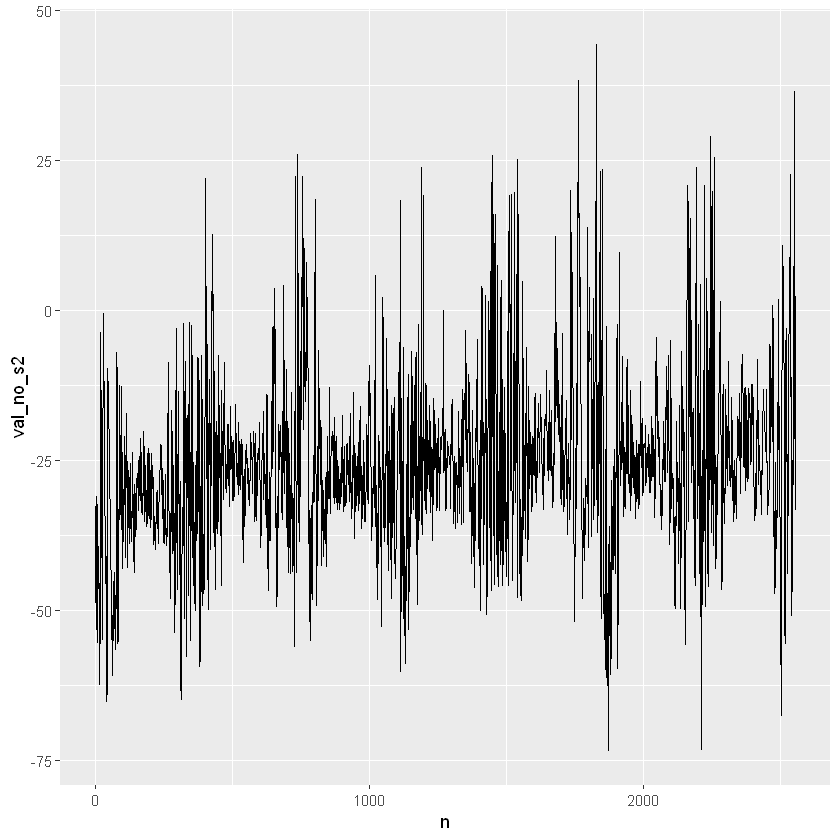

In [202]:
Xt_all$val_no_trend <- Xt_all$val-polyval(lm1,(Xt_all$n))
Xt_all$id <- (Xt_all$n %% 365)+1
Xt_all <- Xt_all %>% left_join(y=season_vals, by=c('id'='n'))
Xt_all$val_no_s2 <- Xt_all$val_no_trend-Xt_all$s_val
ggplot(Xt_all, aes(n, val_no_s2))+geom_line()

In [203]:
#write.csv(Xt_all, 'all_notrend_noseason.csv')